# Sinsistro template

* https://observe.lco.global/requests/3867164
* https://observe.lco.global/requests/3867165

In [1]:
import sys
sys.path.insert(0, "/ut3/jerome/github/research/project/ext_tools/prose2/")

## dataset

In [2]:
from pathlib import Path

###
date: str = "250523"
###
folder = f"/data/Sinistro/{date}/"

sciences: list = sorted(Path(folder).glob("*.fits"))
sciences

[PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0090-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0091-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0092-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0093-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0094-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0095-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0096-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0097-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0098-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0099-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0100-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0101-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1m012-fa06-20250523-0102-e91.fits'),
 PosixPath('/data/Sinistro/250523/cpt1

In [3]:
len(sciences)

1377

In [4]:
from prose import FITSImage

h = FITSImage(sciences[-1]).header
h['OBJECT']

/ut3/jerome/github/research/project/ext_tools/prose2/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


'TIC89071445'

In [5]:
###
target_name: list = 'TIC89071445'
###

In [6]:
from prose.utils import read_filename_per_band

###
bands = ['gp','zs']
###

data: dict = read_filename_per_band(sciences, bands, target_name)

100%|██████████████████████████████████████| 1377/1377 [00:09<00:00, 145.34it/s]


In [7]:
# count filename per band
{b: len(data[b]) for b in bands}

{'gp': 680, 'zs': 697}

## get target coords

In [8]:
from urllib.request import urlopen
import json

url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name.replace(' ','')}&json"
response = urlopen(url)
data_json = json.loads(response.read())
data_json['coordinates']

{'ra': '232.95502667627599',
 'dec': '-34.2705520935164',
 'galactic_long': '336.9213',
 'galactic_lat': '17.8095',
 'ecliptic_long': '239.0181',
 'ecliptic_lat': '-14.72988',
 'pm_ra': '-21.8677',
 'pm_ra_error': '.0960371',
 'pm_dec': '-28.8572',
 'pm_dec_error': '.0662624'}

In [9]:
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(232.955026676276, -34.2705520935164)

## get header info

https://lco.global/observatory/instruments/sinistro/

In [10]:
from prose.utils import get_saturation_from_header

saturation_limits = get_saturation_from_header(h)
saturation_limits

For reference, saturatation in header is 298775.0 ADU and max linearity is 251600.0 ADU.
See url: https://lco.global/observatory/instruments/sinistro/


{'gp': 51515.15151515152,
 'rp': 51515.15151515152,
 'ip': 51515.15151515152,
 'zs': 51515.15151515152}

## choose ref image

In [11]:
from prose import Telescope

###
band = 'gp'
###

ndata = len(data[band])
saturation = saturation_limits[band]
telescope = Telescope(saturation=saturation)
ref_file = data[band][ndata//2]
ref = FITSImage(ref_file, telescope=telescope)

In [12]:
# check attributes
ref.__dict__.keys()

dict_keys(['data', 'metadata', 'catalogs', '_sources', 'origin', 'discard', 'computed', 'header', '_wcs'])

## process ref image

In [13]:
from prose import Sequence, blocks
from prose.blocks.utils import RejectSaturatedSources

###
max_num_stars = 10       # nth brightest stars
cutout_size = 35         # cutout size of detected stars
ccd_trim_size_xy = (0,0) # used trim the edges
min_star_area = 100      # area of stars in pix
min_star_separation = 10 # separation between stars in pix
###

saturation = saturation_limits[band]
calibration = Sequence(
        [
            blocks.Trim(ccd_trim_size_xy),
            # MaskSaturatedPixels(saturation),
            blocks.PointSourceDetection(n=max_num_stars, 
                                        min_area=min_star_area, 
                                        min_separation=min_star_separation),  # stars detection
            RejectSaturatedSources(saturation), # reject saturated sources
            blocks.Cutouts(shape=cutout_size),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
            blocks.CentroidQuadratic(),  # centroiding
            blocks.AperturePhotometry(),  # aperture photometry
            blocks.AnnulusBackground(),  # annulus background
        ]
    )

# run the calibration sequence
calibration.run(ref, show_progress=False)

## plot ref image

Text(0.5, 1.1, 'TIC89071445 gp-band')

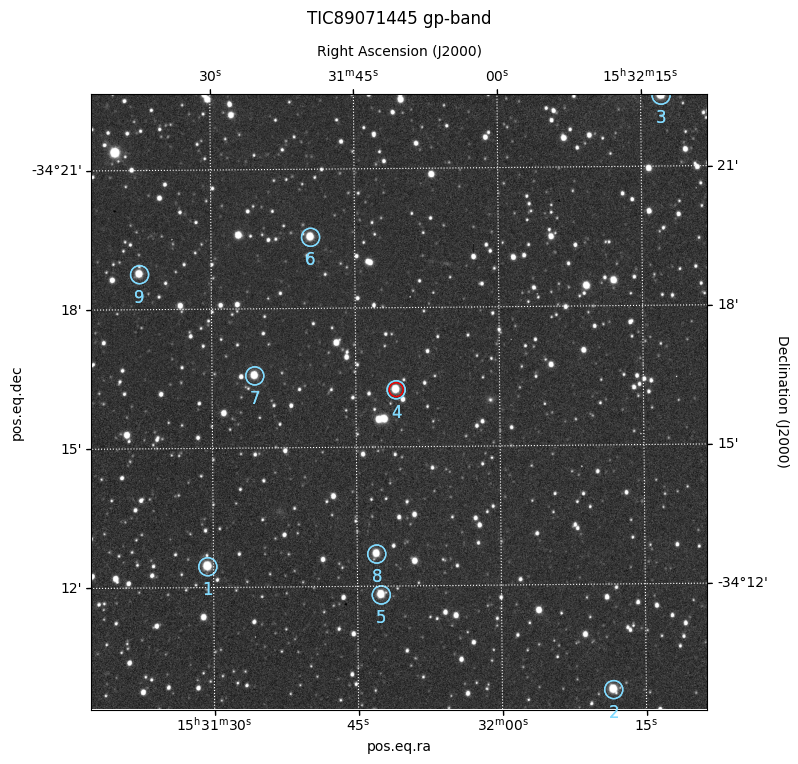

In [14]:
import matplotlib.pyplot as pl
from astropy.wcs import WCS

wcs = WCS(ref.header)
ref.show(frame=True)
ra_pix, dec_pix = wcs.wcs_world2pix([[ra,dec]], 0)[0]
pl.scatter(ra_pix, dec_pix, s=100, ec='r', fc='none')
ref.sources.plot()
pl.title(f"{target_name} {band}-band", y=1.1)

## plot ref image and Simbad objects within FOV

Querying SIMBAD sources within 8.333333333333334 arcmin of 232.955 -34.2706
For description of Simad object types, see https://simbad.cds.unistra.fr/Pages/guide/otypes.htx


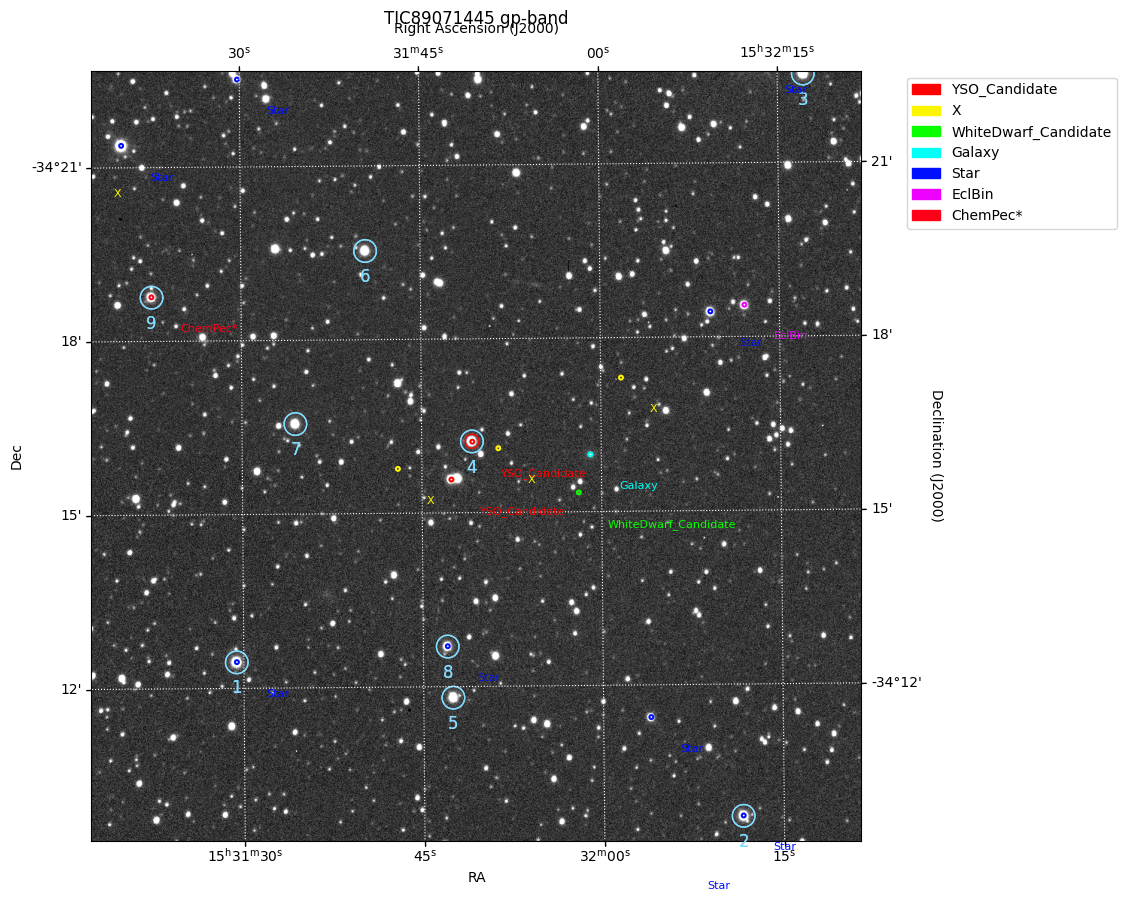

In [24]:
from prose.visualization import plot_fov_simbad
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# Example usage (you'll need to define these variables):
#Plot setup
wcs = WCS(ref.header)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
ref.show(ax=ax, frame=True)

#Plot target
ra_pix, dec_pix = wcs.wcs_world2pix([[ra, dec]], 0)[0]
ax.scatter(ra_pix, dec_pix, s=100, ec='red', fc='none')
ref.sources.plot(ax=ax)
plt.title(f"{target_name} {band}-band", y=1.05)

#Plot SIMBAD data
target_coord = SkyCoord(ra, dec, unit='deg')
_ = plot_fov_simbad(ax, ref.data, target_coord, 
                    # text_offset=(0.01,0.01), # in deg
                    fov_simbad_arcsec=500)

## create video

In [15]:
# Just running it on a test image

###
band = 'gp'
frameid = 10
test_file = data[band][frameid]
###

test_image = FITSImage(test_file, telescope=telescope)

main_sequence = Sequence([
    calibration[0],
    blocks.PointSourceDetection(n=12, minor_length=8),  # fewer stars detection
    blocks.Cutouts(21),  # stars cutouts
    blocks.MedianEPSF(),  # building EPSF
    blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
    blocks.ComputeTransformTwirl(ref),  # compute alignment
    blocks.AlignReferenceSources(ref),  # alignment
    blocks.CentroidQuadratic(),  # centroiding
])

main_sequence.run(test_image)

100%|█████████████████████████████████████████| 1/1 [00:00<00:00,  3.18images/s]


In [16]:
from prose.visualization import plot_image_analysis

###
make_gif = True
every_nth_frame = 100 
###

if make_gif:
    output_gif_filename = f"{target_name.replace(' ','')}_{h['SITEID']}_{band}_{date}_movie.gif" 
    process = Sequence([
        *main_sequence,
        blocks.visualization.VideoPlot(plot_image_analysis, output_gif_filename)
    ])

    # show every n-th image
    process.run(data[band][::every_nth_frame])
    print("Saved: ", output_gif_filename)

100%|█████████████████████████████████████████| 7/7 [00:05<00:00,  1.36images/s]

Saved:  TIC89071445_cpt_gp_250523_movie.gif


## check detected reference stars

In [25]:
ref.computed.keys()

dict_keys(['telescope', 'i', 'cutouts', 'epsf', 'epsf_n_sources', 'fwhm', 'aperture', 'annulus'])

In [26]:
len(ref.computed['cutouts'])

9

Text(0.5, 0.98, 'TIC89071445\ngp-band 250523 focus=0.01 airmass=1.09')

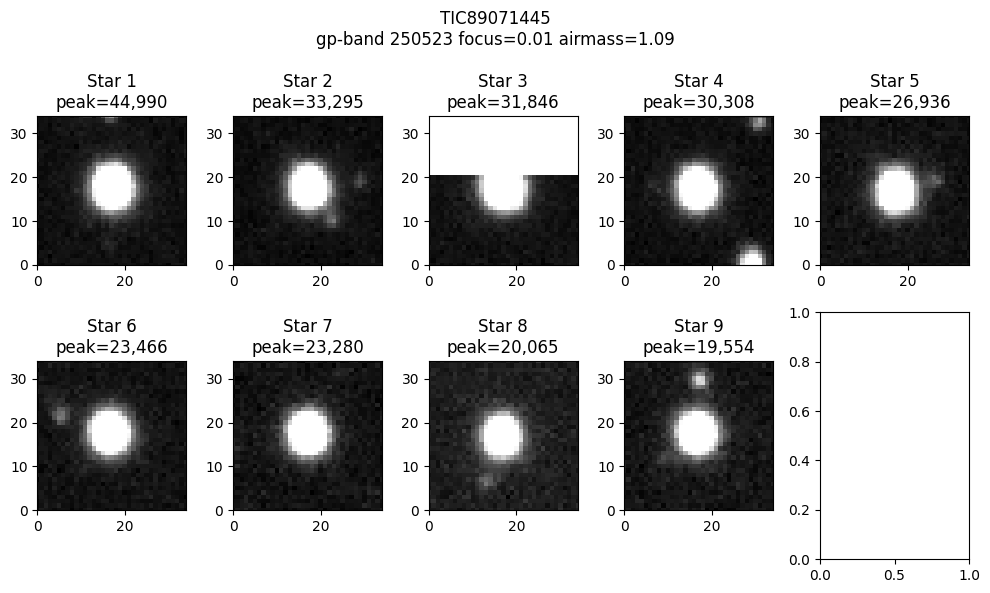

In [28]:
import matplotlib.pyplot as pl

ncutouts = len(ref.computed['cutouts'])
nrows = 2
ncols = ncutouts//nrows if ncutouts%2==0 else ncutouts//nrows+1
fig, axs = pl.subplots(nrows, ncols, figsize=(10,6), tight_layout=True)
ax = axs.flatten()
for i,img in enumerate(ref.computed['cutouts']):
    img.show(ax=ax[i])
    peak = ref._sources[i].peak
    # peak = np.nanmax(img.data)
    ax[i].set_title(f"Star {i+1}\npeak={peak:,.0f}")
focus = ref.header['FOCPOSN']
z = ref.header['AIRMASS']
fig.suptitle(f"{target_name}/{band}-band ({date})\nfocus={focus:.2f} airmass={z:.2f}")

In [29]:
ref.aperture.keys()

dict_keys(['fluxes', 'radii'])

In [30]:
ref.aperture['radii']

array([ 0.62911807,  0.74204128,  0.87523358,  1.03233315,  1.21763124,
        1.4361893 ,  1.69397732,  1.99803686,  2.3566734 ,  2.77968322,
        3.27862096,  3.86711525,  4.56124101,  5.3799585 ,  6.34563124,
        7.48463689,  8.82808774, 10.41268057, 12.28169904, 14.48619597,
       17.08638788, 20.15329983, 23.77070548, 28.0374154 , 33.06997611,
       39.00585358, 46.00718817, 54.26522353, 64.00553047, 75.49416854])

## plot nearby stars

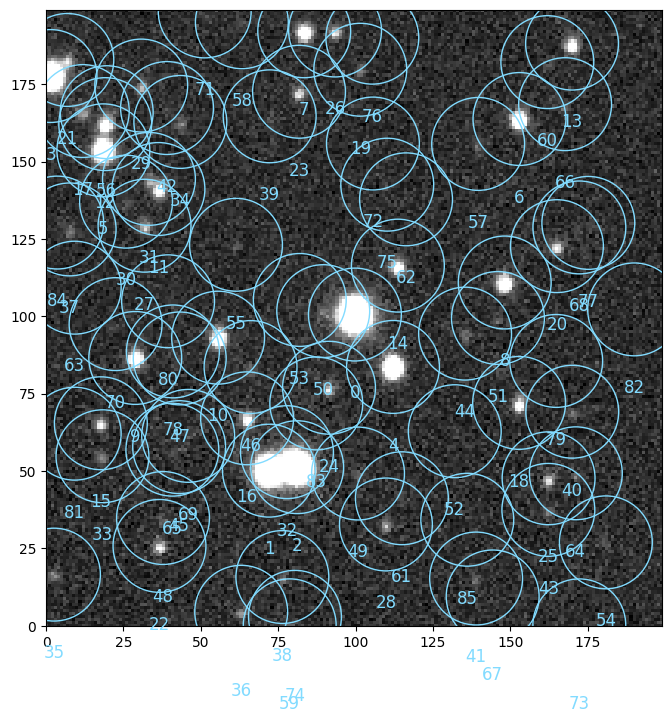

In [24]:
from prose.blocks import catalogs
import astropy.units as u

###
tid = 4
###

c = ref.cutout(ref.sources[tid].coords, (200, 200)) #make a larger cutout to see nearby Gaia sources

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
# mode="crossmatch" to match existing Image.sources 
# mode="replace" to use queried stars as Image.sources
c.show()

In [25]:
c.catalogs['gaia'].head()

index          solution_id                            id  \
0      0  1635721458409799680  Gaia DR2 6014331902471694464   
1      1  1635721458409799680  Gaia DR2 6014331906769737984   
2      2  1635721458409799680  Gaia DR2 6014331906769737856   
3      3  1635721458409799680  Gaia DR2 6014330394941243392   
4      4  1635721458409799680  Gaia DR2 6014331906769736448   

             SOURCE_ID  random_index  ref_epoch          ra  ra_error  \
0  6014331902471694464     483270431     2015.5  232.954953  0.056645   
1  6014331906769737984    1289316337     2015.5  232.947570  0.069263   
2  6014331906769737856     627321601     2015.5  232.949959  0.040060   
3  6014330394941243392    1111942320     2015.5  232.929384  0.040637   
4  6014331906769736448     114859943     2015.5  232.958136  0.063136   

         dec  dec_error  ...  radius_val  radius_percentile_lower  \
0 -34.270632   0.031277  ...    1.045749                 0.896411   
1 -34.259775   0.036196  ...    0.994210                 0.913827   
2 -34.260000   0.019198  ...    1.447507                 1.396697   
3 -34.287484   0.022556  ...    1.908165                 1.533652   
4 -34.266947   0.030620  ...    1.102655                 1.011260   

   radius_percentile_upper   lum_val  lum_percentile_lower  \
0                 1.117964  0.271078              0.268560   
1                 1.074304  0.181338              0.179564   
2                 1.511825  1.190238              1.142158   
3                 2.284996  2.174774              1.970118   
4                 1.223113  0.550233              0.500233   

   lum_percentile_upper                                       datalink_url  \
0              0.273596  https://gea.esac.esa.int/data-server/datalink/...   
1              0.183112  https://gea.esac.esa.int/data-server/datalink/...   
2              1.238319  https://gea.esac.esa.int/data-server/datalink/...   
3              2.379430  https://gea.esac.esa.int/data-server/datalink/...   
4              0.600233  https://gea.esac.esa.int/data-server/datalink/...   

   epoch_photometry_url           x           y  
0                         99.762002  100.563709  
1                         71.993920   50.131684  
2                         81.110876   51.252203  
3                          1.428171  177.618525  
4                        112.069602   83.634285  

[5 rows x 99 columns]

## determine nearest star

In [26]:
df = c.catalogs['gaia'].copy()
df.head()

index          solution_id                            id  \
0      0  1635721458409799680  Gaia DR2 6014331902471694464   
1      1  1635721458409799680  Gaia DR2 6014331906769737984   
2      2  1635721458409799680  Gaia DR2 6014331906769737856   
3      3  1635721458409799680  Gaia DR2 6014330394941243392   
4      4  1635721458409799680  Gaia DR2 6014331906769736448   

             SOURCE_ID  random_index  ref_epoch          ra  ra_error  \
0  6014331902471694464     483270431     2015.5  232.954953  0.056645   
1  6014331906769737984    1289316337     2015.5  232.947570  0.069263   
2  6014331906769737856     627321601     2015.5  232.949959  0.040060   
3  6014330394941243392    1111942320     2015.5  232.929384  0.040637   
4  6014331906769736448     114859943     2015.5  232.958136  0.063136   

         dec  dec_error  ...  radius_val  radius_percentile_lower  \
0 -34.270632   0.031277  ...    1.045749                 0.896411   
1 -34.259775   0.036196  ...    0.994210                 0.913827   
2 -34.260000   0.019198  ...    1.447507                 1.396697   
3 -34.287484   0.022556  ...    1.908165                 1.533652   
4 -34.266947   0.030620  ...    1.102655                 1.011260   

   radius_percentile_upper   lum_val  lum_percentile_lower  \
0                 1.117964  0.271078              0.268560   
1                 1.074304  0.181338              0.179564   
2                 1.511825  1.190238              1.142158   
3                 2.284996  2.174774              1.970118   
4                 1.223113  0.550233              0.500233   

   lum_percentile_upper                                       datalink_url  \
0              0.273596  https://gea.esac.esa.int/data-server/datalink/...   
1              0.183112  https://gea.esac.esa.int/data-server/datalink/...   
2              1.238319  https://gea.esac.esa.int/data-server/datalink/...   
3              2.379430  https://gea.esac.esa.int/data-server/datalink/...   
4              0.600233  https://gea.esac.esa.int/data-server/datalink/...   

   epoch_photometry_url           x           y  
0                         99.762002  100.563709  
1                         71.993920   50.131684  
2                         81.110876   51.252203  
3                          1.428171  177.618525  
4                        112.069602   83.634285  

[5 rows x 99 columns]

In [27]:
from astropy.coordinates import SkyCoord

target_coord = SkyCoord(ra, dec, unit='deg')
gaia_coords = SkyCoord(df.ra, df.dec, unit='deg')

In [28]:
df['sep_arcsec'] = target_coord.separation(gaia_coords).arcsec
df['sep_pix'] = (df['sep_arcsec']/ref.header['PIXSCALE']).round() #pixel
df = df.sort_values(by='sep_arcsec').reset_index(drop=True)
df.sep_pix.head()

0     0.0
1    11.0
2    19.0
3    20.0
4    21.0
Name: sep_pix, dtype: float64

In [29]:
#nearest star
aper_rad_max_pix = 20 #df.iloc[1].sep_pix
aper_rad_max_pix

20

In [30]:
###
aper_rad_min_pix = round(ref.fwhm)
###

aper_rad_min_pix

6

In [31]:
assert aper_rad_min_pix<aper_rad_max_pix

In [32]:
default_radii = ref.aperture['radii']
len(default_radii)

30

In [33]:
import numpy as np

# the default aperture radii in blocks.AperturePhotometry() is scaled by fwhm like so:
np.exp(np.linspace(np.log(0.1), np.log(12), 30))*ref.fwhm

array([ 0.64361128,  0.75913594,  0.89539663,  1.05611536,  1.24568222,
        1.46927528,  1.73300205,  2.04406631,  2.41096489,  2.84371973,
        3.35415167,  3.9562033 ,  4.66631988,  5.50389844,  6.49181771,
        7.65706302,  9.0314634 , 10.65256104, 12.56463672, 14.8199194 ,
       17.48001281, 20.61757826, 24.31831931, 28.68332288, 33.83182041,
       39.90444471, 47.06707143, 55.51534996, 65.48004767, 77.23335341])

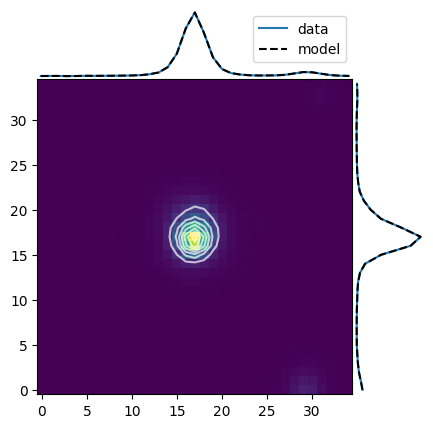

In [34]:
# how's the FWHM like?
c = ref.computed['cutouts'][tid]
c.plot_model(c.data, contour=True)

## set aperture radii and background annulus (pix)

In [35]:
aper_radii = np.arange(aper_rad_min_pix, aper_rad_max_pix, 2)
aper_radii

array([ 6,  8, 10, 12, 14, 16, 18])

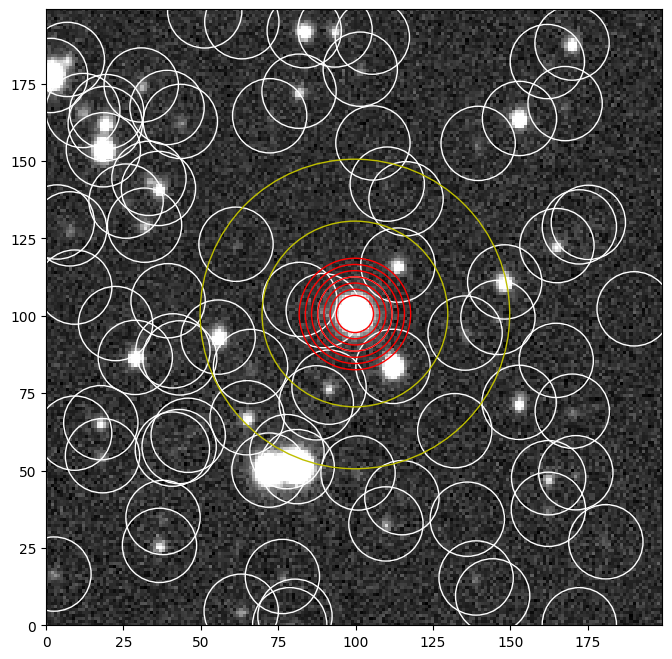

In [36]:
import numpy as np

c = ref.cutout(ref.sources[tid].coords, (200, 200))
c.show(zscale=True, sources=False)

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
c.plot_catalog("gaia", label=False, color="w")

# aperture radii
for r in aper_radii: 
    c.sources[0].plot(r, label=False, c="r")
    
# background annulus
dr = 20
rin = aper_rad_max_pix+10
rout = rin+dr #in units of fwhm
c.sources[0].plot(rin, label=False, c="y")
c.sources[0].plot(rout, label=False, c="y")

## check PSF model

Text(0.5, 1.0, 'diff')

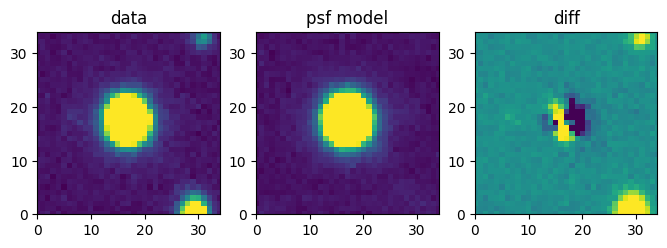

In [37]:
import matplotlib.pyplot as pl
from prose import Image

cmap='viridis'
fig, axs = pl.subplots(1,3, figsize=(8,3))
ax = axs.flatten()

c=ref.computed['cutouts'][tid]
c.show(ax=ax[0], cmap=cmap)
ax[0].set_title('data')
epsf=ref.computed['epsf']
epsf.show(ax=ax[1], cmap=cmap)

# params = epsf.params
# model = Image(epsf.model(params))
# model.show(ax=ax[1], cmap=cmap)
ax[1].set_title('psf model')
d = Image(c.data/c.data.max()-epsf.data)
d.show(ax=ax[2], cmap=cmap)
ax[2].set_title('diff')

## reduction

In [80]:
import numpy as np
from prose import FITSImage, Sequence, blocks
from prose.core.sequence import SequenceParallel

###
nstars = 10
cutout_shape = 31
scale_radii_to_fwhm = False 
###

def run_phot(data, ref, saturation=None):
    
    calibration = Sequence(
        [
            blocks.Trim(),
            blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # stars detection
            RejectSaturatedSources(saturation),
            blocks.Cutouts(shape=cutout_shape),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
        ]
    )
    
    calibration.run(ref, show_progress=False)
    
    phot = SequenceParallel(
        blocks=[
                calibration[0],  # trim from calibration block (same as above)
                blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # fewer stars detection
                RejectSaturatedSources(saturation),
                blocks.Cutouts(shape=cutout_shape),  # stars cutouts
                blocks.MedianEPSF(),  # building EPSF
                blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
                blocks.ComputeTransformTwirl(ref, n=nstars),  # compute alignment
                blocks.AlignReferenceSources(ref),  # alignment
                blocks.CentroidQuadratic(),  # centroiding
                blocks.AperturePhotometry(aper_radii, scale=scale_radii_to_fwhm),  # aperture photometry
                blocks.AnnulusBackground(rin=rin, rout=rout, scale=scale_radii_to_fwhm),  # annulus background
                ],
        data_blocks=[
                blocks.GetFluxes(
                    "fwhm",
                    airmass=lambda im: im.header["AIRMASS"],
                    dx=lambda im: im.transform.translation[0],
                    dy=lambda im: im.transform.translation[1],
                    peak=lambda im: np.nanmax(im.data)
                ),
            ],
        )
        
    phot.run(data)
    
    return dict(phot=phot, ref=ref)

phot = {}
for band in bands:
    saturation = saturation_limits[band]
    phot[band] = run_phot(data[band], ref, saturation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 697/697 [00:41<00:00, 16.64images/s]


## photometry data

In [85]:
phot[band]['phot']

╒═════════╤════════╤════════════════════════╤════════════════╕
│   index │ name   │ type                   │ processing     │
╞═════════╪════════╪════════════════════════╪════════════════╡
│       0 │        │ Trim                   │ 0.008 s (100%) │
├─────────┼────────┼────────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection   │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       2 │        │ RejectSaturatedSources │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       3 │        │ Cutouts                │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       4 │        │ MedianEPSF             │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       5 │        │ Gaussian2D             │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       6 │        │ ComputeTransformTwirl  │ 0.000 s (

In [40]:
phot[band]['phot'].__dict__.keys()

dict_keys(['name', 'images', 'blocks_dict', 'data', 'n_processed_images', 'last_image', 'buffer', '_has_data', 'progress', 'discards'])

In [48]:
phot[band]['phot'].data[0].__dict__.keys()

dict_keys(['_time_key', '__doc__', 'name', 'unit_data', 'processing_time', 'runs', 'in_sequence', 'verbose', '_data_block', 'size', 'read', 'getters', 'values', 'arrays', '_parallel_friendly', 'fluxes'])

## reference frames

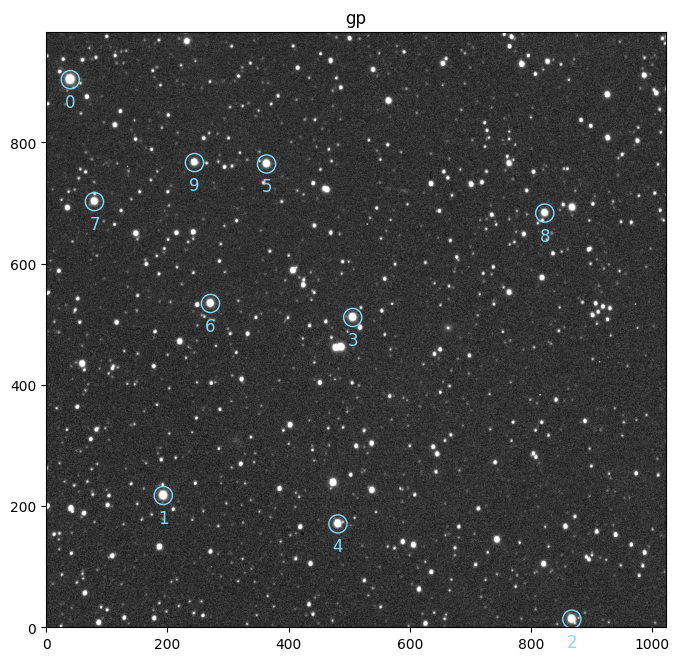

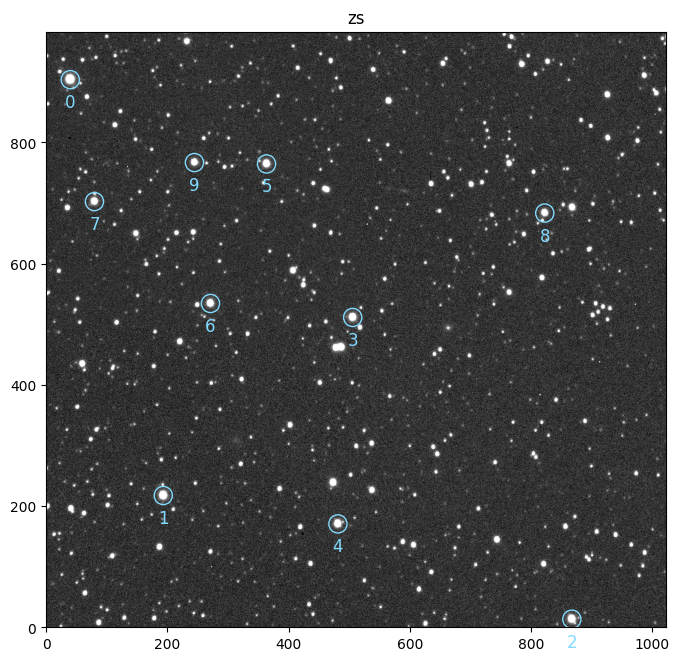

In [41]:
from prose import Fluxes
import matplotlib.pyplot as plt

for band in bands:
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    phot[band]['ref'].show()
    plt.title(band)

In [42]:
fluxes.__dict__.keys()

dict_keys(['fluxes', 'time', 'errors', 'data', 'apertures', 'weights', 'target', 'aperture', 'metadata'])

In [43]:
fluxes.target = tid
aper_idx = fluxes.best_aperture_index()
aper_idx

3

In [44]:
fluxes.shape #aper, nstars, ndata

(7, 10, 697)

## absolute photometry

## differential photometry

In [86]:
import matplotlib.pyplot as plt

def get_diff_phot(fluxes, target, plot=True, color='k', ax=None):
    
    fluxes.target = target
    
    # a bit of cleaning
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    
    # differential photometry
    diff = fluxes.autodiff()
    
    if plot:
        # plotting
        bin = diff.bin(10 / 60 / 24, estimate_error=True)            
        ax.errorbar(bin.time, bin.flux, bin.error, c=color, ls='', marker='o')
        diff.plot(ax=ax)
        if True:
            # show ingress, midpoint, egress
            ax.axvline(ing0[0], 0, 1, ls='--', c='k')
            ax.axvline(mid0[0], 0, 1, ls='-', c='k')
            ax.axvline(egr0[0], 0, 1, ls='--', c='k')
    return diff

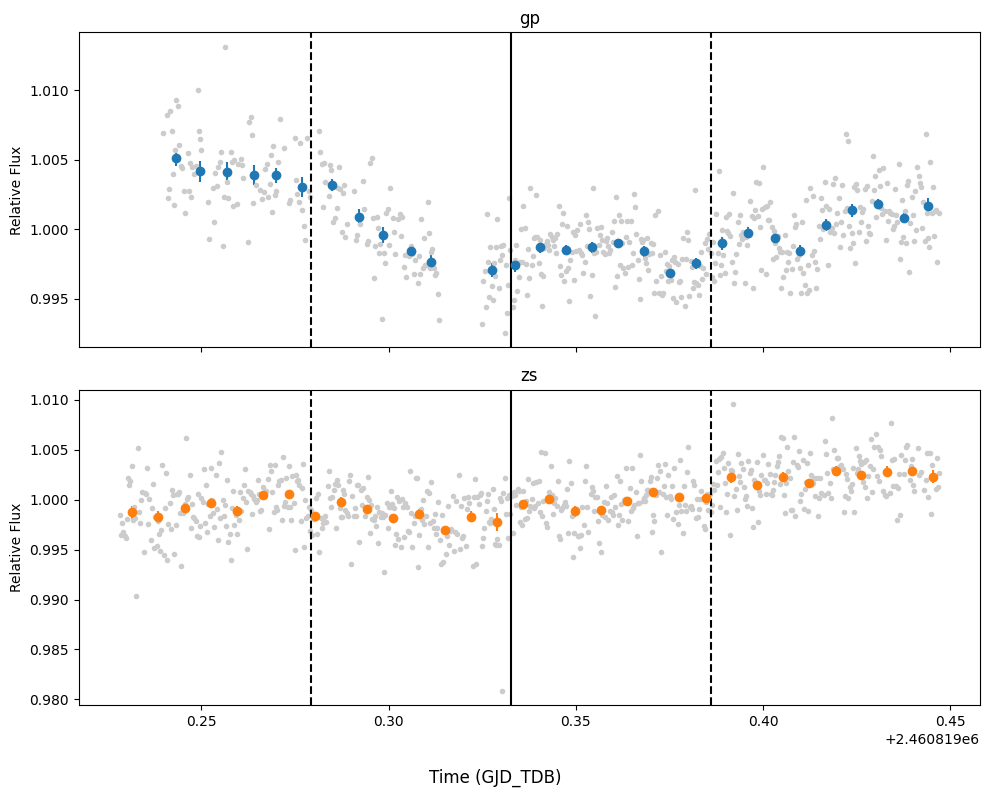

In [87]:
diffs = {}
tids = [tid]*len(bands)
fig, axs = plt.subplots(len(bands), 1, figsize=(10, 8), sharex=True)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i}', ax=axs[i])
    diffs[band] = diff
    axs[i].set_title(band)
    axs[i].set_ylabel("Relative Flux")
fig.supxlabel("Time (GJD_TDB)")
fig.tight_layout()

In [89]:
diff.data.keys()

dict_keys(['bkg', 'airmass', 'dx', 'dy', 'peak', 'fwhm'])

## GJD_UTC to BJD_TDB conversion

In [90]:
from astroplan import Observer
from astropy.coordinates import SkyCoord
from astropy.time import Time

lco_sites = {
    # astroplan observatory site codes
    # LCO-1m
    "LCOGT node at SAAO": "saao",
    "LCOGT node at Tenerife": "teide",
    "LCOGT node at McDonald Observatory": "McDonald",
    "LCOGT node at Cerro Tololo Inter-American Observatory": "cerro tololo interamerican observatory",
    # LCO-2m
    "LCOGT node at Haleakala Observatory" : "Haleakala",
    "LCOGT node at Siding Spring Observatory": "Siding Spring Observatory",
    }
lco_codes = {
    #lco observatory site codes
    "LCOGT node at Siding Spring Observatory": "coj",
    "LCOGT node at Cerro Tololo Inter-American Observatory": 'lsc',
    "LCOGT node at SAAO": 'cpt',
    "LCOGT node at Tenerife": 'tfn'
}

site = ref.header['site']
obs_site = Observer.at_site(lco_sites[site])
obj_coord = SkyCoord(ra=ra, dec=dec, unit=("deg","deg"))

###
use_barycorrpy = False
###

bjds = {}
for band in bands:
    gjd = diffs[band].time
    t = Time(gjd, format='jd', scale='utc', location=obs_site.location)

    if use_barycorrpy:
        #https://arxiv.org/pdf/1801.01634.pdf
        try:
            from barycorrpy import utc_tdb
        except:
            raise ImportError("pip install barycorrpy")
        #convert jd to bjd_tdb
        result = utc_tdb.JDUTC_to_BJDTDB(t.value, 
                                         ra=obj_coord.ra.deg, 
                                         dec=obj_coord.dec.deg, 
                                         lat=obs_site.location.lat.deg, 
                                         longi=obs_site.location.lon.deg, 
                                         alt=obs_site.location.height.value)
        bjds[band] = result[0]
        offset = result[0]-t.value        
    else:
        #BJD time format in TDB time scale
        #see MuSCAT2_transit_pipeline/muscat2ph/phdata.py l218
        lttd = t.light_travel_time(obj_coord, kind='barycentric')
        bjd_tdb = t.tdb + lttd
        bjds[band] = bjd_tdb
        offset = bjd_tdb.value - t.jd
        #check difference between two time scales (should be < 8 mins!)
    offset_in_minutes = np.median(offset)*24*60
    msg = f"computed GJD-TDB offset={offset_in_minutes:.3} min"
    assert offset_in_minutes<=2*8.3, errmsg+" > 2*8.4 min!"
print(msg)

computed GJD-TDB offset=9.34 min


## export photometry into csv

In [91]:
import pandas as pd

###
save_csv = True
outdir = "."
#date = ref.header['DAY-OBS'][2:]
###

for band,diff in diffs.items():
    df = diff.df.copy()
    df['BJD_TDB'] = bjds[band]
    df['Flux_Err'] = diff.error
    # rename columns
    df = df.rename({'time': 'GJD_UTC',
                    'flux': 'Flux',
                    'airmass': 'Airmass',
                    'dx': 'Dx(pix)',
                    'dy': 'Dy(pix)',
                    'bkg': 'Bkg(ADU)',
                    'fwhm': 'FWHM(pix)',
                    'peak': 'Peak(ADU)'
                   }, axis=1)
    print(df.head())
    if save_csv:
        fp = f"{outdir}/{target_name.replace(' ', '')}_{date}_{inst.lower()}_{lco_codes[site]}_{band[0]}_prose.csv"
        df.to_csv(fp, index=False)
        print("Saved: ", fp) 

    Bkg(ADU)   Airmass   Dx(pix)    Dy(pix)     Peak(ADU)  FWHM(pix)  \
0  94.235911  1.660693 -3.304323 -14.379677  47663.863281   3.441818   
1  94.656318  1.650246 -2.634146 -17.731419  35628.199219   3.499104   
2  94.064083  1.646864 -3.357823 -14.248301  54532.445312   3.195077   
3  94.028267  1.643501 -2.944451 -14.292672  54095.550781   3.244659   
4  93.726484  1.639664 -3.617995 -13.155505  43181.183594   3.247450   

        GJD_UTC      Flux             BJD_TDB  Flux_Err  
0  2.460819e+06  1.006937  2460819.2462390168  0.002306  
1  2.460819e+06  1.008222  2460819.2472041054  0.002291  
2  2.460819e+06  1.002256   2460819.247519174  0.002310  
3  2.460819e+06  1.002923  2460819.2478328417  0.002309  
4  2.460819e+06  1.008513   2460819.248196023  0.002303  
Saved:  ./TIC89071445_250523_sinistro_cpt_g_prose.csv
     Bkg(ADU)   Airmass   Dx(pix)    Dy(pix)     Peak(ADU)  FWHM(pix)  \
0  392.196489  1.798762  0.307227 -49.849675  57783.742188   2.515241   
1  389.125842  1.79

## plots

Text(0.5, 0.98, 'TIC89071445 | Sinistro | 250523')

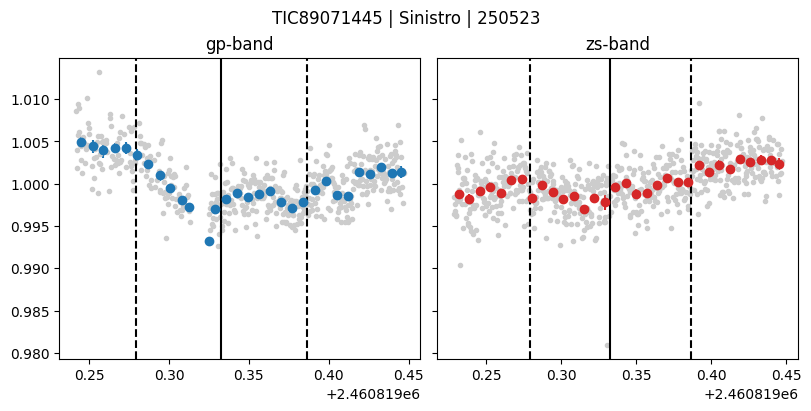

In [93]:
import pandas as pd

fig, axs = pl.subplots(1, 2, figsize=(8,4), sharex='col', sharey='row', constrained_layout=True)
ax = axs.flatten()
for i,band in enumerate(bands):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i*3}', ax=ax[i])
    ax[i].set_title(f"{band}-band")
fig.suptitle(f"{target_name} | {inst} | {date}")

And here is our planetary transit. To validate the differential photometry and the automatic choice of comparison stars, we can plot their light curves along the target light curve

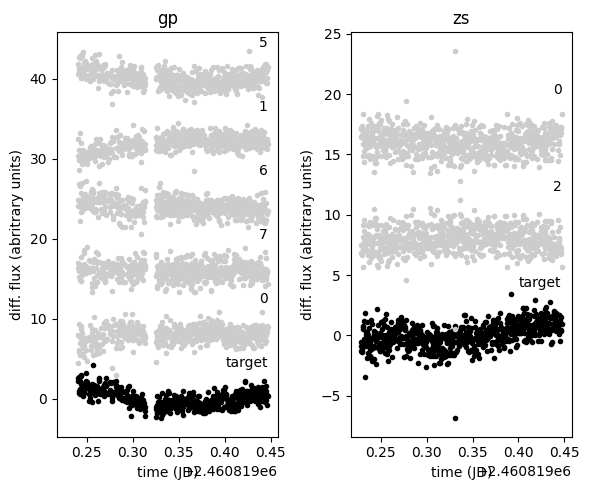

In [97]:
def plot_comp(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    # plotting only the first five comparisons
    for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
        y = diff.fluxes[diff.aperture, i].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * j
        ax.text(
            diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
        )
        ax.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="diff. flux (abritrary units)")
    
fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_comp(diff, ax=axs[i])
    axs[i].set_title(band)

fig.tight_layout()

# Explanatory measurements

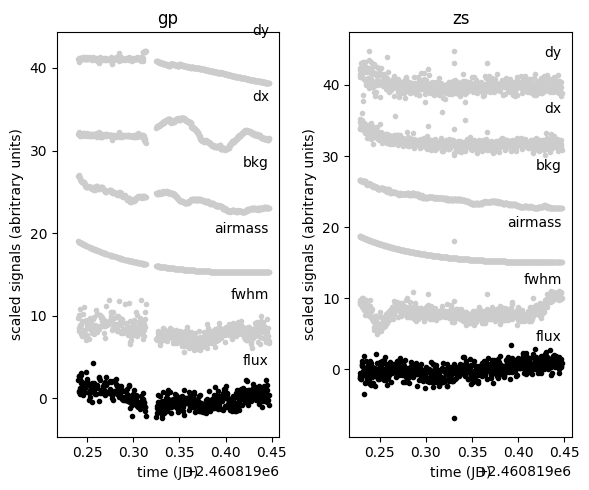

In [56]:
def plot_aux(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy", "peak"]):
        y = diff.df[name].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * i
        ax.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
        ax.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_aux(diff, ax=axs[i])
    axs[i].set_title(band)
    
fig.tight_layout()

## quick look plot

In [3]:
import sys
sys.path.insert(0, "/ut3/muscat/github/tfop_code/")

In [100]:
import pandas as pd

data = {}
target_name = 'TIC89071445'
date = 250523
instrument = 'sinistro'
site = 'cpt'
pipeline = 'prose'
data['g'] = pd.read_csv(f'./{target_name}_{date}_{instrument}_{site}_g_{pipeline}.csv')
data['z'] = pd.read_csv(f'./{target_name}_{date}_{instrument}_{site}_z_{pipeline}.csv')

In [ ]:
from tfop_analysis import plot_ql, colors
from aesthetic.plot import savefig

exptimes = {'g': 20, 'z': 20}
for i,b in enumerate(data):
    fig = plot_ql(data[b],
                  title=f'{target_name}.01 | LCO-1m/{instrument} | {date} | {b}=band',
                  exptime=exptimes[b],
                  mcolor=colors[b],
                  binsize=10/60/24,
                  figsize=(10,10),
                  font_size=16,
                  title_height=0.93
                 )
    if False:
        outfile = f"{outdir}/{target}.01_{date}_{inst}_{b}_ql.pdf"
        fig.savefig(outfile, dpi=300)